In [8]:
import os
import time

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# utils import
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [9]:
movies_filename = 'movies_scrape1.csv'
ratings_filename = 'ratings_scrape1.csv'

In [10]:
df_movies = pd.read_csv(movies_filename,
    usecols=['movieId', 'title'],
    dtype={'movieId': 'int32', 'title': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'int32'})

In [11]:
df_movies.loc[:15,:]

,movieId,title
0,1,Housefull 4
1,2,War
2,3,Bigil
3,4,Hotel Mumbai
4,5,Saand Ki Aankh
5,6,Ready Player One
6,7,Ghost
7,8,Jumanji: Welcome to the Jungle
8,9,Made in China
9,10,The Family Man


In [12]:
print(df_ratings.loc[:15,:] ,
"\n File dimensions ",df_ratings.shape)

    userId  movieId  rating
0        0      500      10
1        0      459       8
2        0      582       1
3        0      937      10
4        0      624       8
5        0      375       6
6        0      209      10
7        0      947       6
8        0      425       1
9        0       14       5
10       0      417      10
11       0      818       4
12       0      214      10
13       0      152       8
14       1      378      10
15       1      435       1 
 File dimensions  (17872, 3)


In [13]:
# determining the number of unique users and movies in the dataset
num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this dataset'.format(num_users, num_items))

There are 1000 unique users and 880 unique movies in this dataset


In [14]:
# Getting the count of each type of rating
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
1,2093
2,588
3,580
4,659
5,707
6,923
7,1468
8,2395
9,2622


In [15]:
# clearly the rating of 0 is missing. Therefore, adding 0s
# df_ratings.shape[0] indicates the number of rows in ratings table(userid movieid rating) i.e., total other ratings
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]
# append counts of zero rating to df_ratings_cnt
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt.head(2)


,count
0.0,862128
1.0,2093


Text(0, 0.5, 'number of ratings')

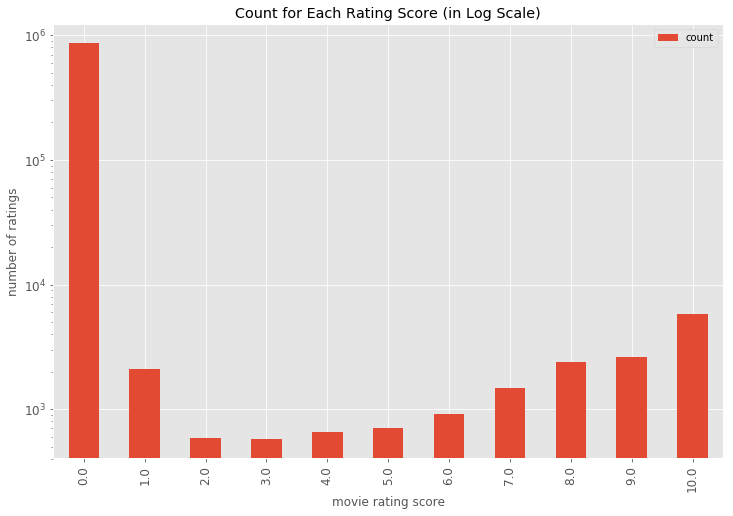

In [16]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

Text(0, 0.5, 'number of ratings')

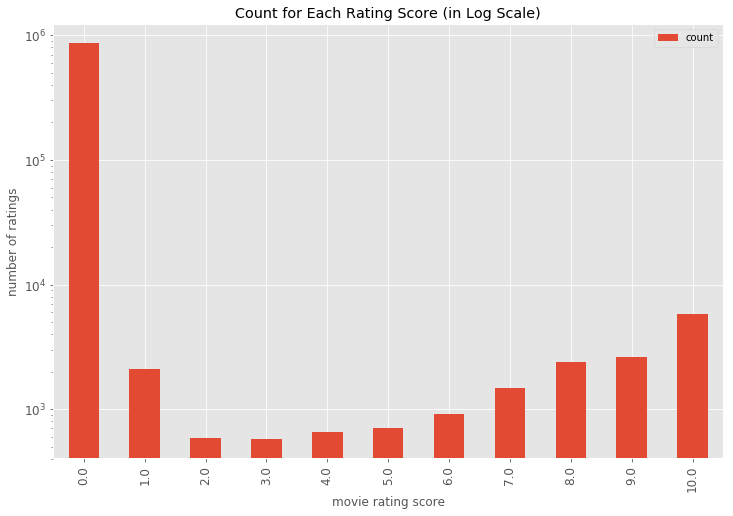

In [19]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

In [20]:
# get rating frequency for the movie
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()


,count
movieId,
1,25
2,24
3,25
4,24
5,25


In [24]:
# filtering data to get only popular items i.e., movies with > 2 ratings
popularity_thres = 5
df_movies_cnt.query('count >= @popularity_thres').head()
# returns movies > 20 ratings

,count
movieId,
1,25
2,24
3,25
4,24
5,25


In [25]:
df_movies_cnt.query('count >= @popularity_thres').index
# gives index of all the movies>20 ratings

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            988, 989, 990, 991, 992, 993, 994, 997, 998, 999],
           dtype='int64', name='movieId', length=823)

In [26]:
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
# df_ratings.movieId.isin(popular_movies) gives boolean list with true ony where movie id is present in popular_movies

In [27]:
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (17872, 3)
shape of ratings data after dropping unpopular movies:  (17746, 3)


In [28]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
0,14
1,17
2,13
3,13
4,17


In [29]:
# filter data such that users who have rated > 50 movies are considered
ratings_thres = 10
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)
#print(df_ratings_drop_users.head())

shape of original ratings data:  (17872, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (17611, 3)


In [31]:
df_ratings_drop_users.sort_values(by='movieId').head()

,userId,movieId,rating
4133,227,1,1
11196,622,1,1
13459,752,1,1
16473,923,1,1
16491,924,1,1


In [32]:
# pivot :  reshaping data(index->what field you want as rows, column->what fields you want as columns, values-> it will only show these fields)
# pivot_table : is used to summarize and aggregate data in dataframe
# pivot and create movie-user matrix
# Enumerate() method adds a counter to an iterable and returns it in a form of enumerate object. 
movie_user_mat = df_ratings_drop_users.reset_index().pivot_table(index='movieId', columns='userId', values='rating', aggfunc = 'mean').fillna(0)
# create mapper from movie title to index mapper = dictionary
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
# csr matrix is a compressed representation of the matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

In [33]:
movie_user_mat.head()

userId,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# “No space left on device” error while fitting Sklearn model 
# This problem occurs when shared memory is consumed and no I/O operation is permissible. This is a frustrating problem that occurs to most of the Kaggle users while fitting machine learning models.
#I overcame this problem by setting JOBLIB_TEMP_FOLDER variable using following code.

%env JOBLIB_TEMP_FOLDER=/tmp

# n_neighbors : Number of neighbors to use

# algorithm : {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, optional
# ‘brute’ will use a brute-force search.

# metric : string or callable, default ‘minkowski’
# metric to use for distance computation. Any metric from scikit-learn or scipy.spatial.distance can be used.

# n_jobs : The number of parallel jobs to run for neighbors search. 
#  If set to -1, all CPUs are used.

# creating an instance of NearestNeighbours class
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

# fit
model_knn.fit(movie_user_mat_sparse)

env: JOBLIB_TEMP_FOLDER=/tmp


NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=-1, n_neighbors=20, p=2, radius=1.0)

In [35]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
# fuzzywuzzy library where we can have a score out of 100, that denotes two string are equal by giving similarity index.
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
# ratio > 60 implies the presence of same words
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]



def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # numpy.squeeze() function is used when we want to remove single-dimensional entries from the shape of an array.
    # [:0:-1] (slicing) reversing the list 
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    print(reverse_mapper[400])
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [36]:
my_favorite = 'Wazir'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=5)

You have input movie: Wazir
Found possible matches in our database: ['Wazir', 'War', 'Baazigar', 'Aamir', 'Akira', 'Airaa', 'Water', 'Raazi']

Recommendation system start to make inference
......

Recommendations for Wazir:
Bekaaboo
1: Darkness Visible, with distance of 0.8707559415198974
2: Blackmail, with distance of 0.8700265912867791
3: Mujhse Dosti Karoge!, with distance of 0.8647386199798838
4: Befikre, with distance of 0.8603969591629184
5: Golmaal: Fun Unlimited, with distance of 0.8551034093766665
